# Agent-Based Traffic Model

## Background

This model is a looped implementation of the cellular automata (CA) described by Nagel and Schreckenberg (NaSch).
The NaSch CA model splits agent (vehicle) actions into four stages:
1. Acceleration
2. Braking
3. Randomisation
4. Vehicle Movement

In this implementation the 4th action is separated from the other actions to simulate simultaneous activation of the agents.
This isn't strictly necessary for non-multithreaded processes but ensures that vehicle positions wouldn't cause conflicts if it were multithreaded.

## Implementation
The model is written in Python using the Mesa ABM framework which allows for easy visualisation.
This is a demonstration of running a Mesa model in an IPython Notebook which is an alternative to running it using javascript visualisation in a webpage.

The actual model and agent code are implemented in model.py, in the same directory as this notebook.
Below, we will import the model class, instantiate it, run it, and plot the average speed of the agents.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

from model import NaSchTraffic

Now we instantiate a model instance: a 1x30 grid, with a 20% chance of an agent being placed in each cell, and a max vehicle speed of 4.

In [2]:
model = NaSchTraffic(1, 30, 0.2, 4, seed=1)

We want to run the model until it's settles, but it's hard to tell when that is so let's just run it for 100 steps:

In [3]:
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

100


The model has a DataCollector object, which checks and stores the average speed of the agents at every step.
It also collects the individual speed and position of each agent at each step.
It can also generate a pandas DataFrame of the data it has collected.

In [4]:
model_out = model.datacollector.get_model_vars_dataframe()

The dataframe for the model:

In [5]:
model_out.head()

,AverageSpeed
0,0.000000
1,0.666667
2,1.166667
3,1.166667
4,2.000000


Finally, we can plot the 'AverageSpeed' series:

<AxesSubplot:>

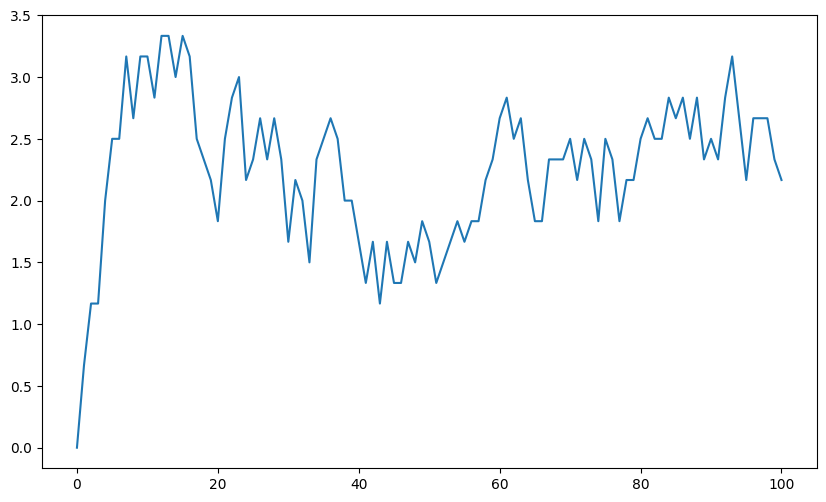

In [6]:
model_out.AverageSpeed.plot()

For testing purposes, here is the dataframe for the agents giving each agent's x position and speed at each step.

In [7]:
agent_out = model.datacollector.get_agent_vars_dataframe()
agent_out.head()

PosX  Speed
Step AgentID             
0    (0, 0)     27      0
     (2, 0)      3      0
     (7, 0)      0      0
     (16, 0)    12      0
     (17, 0)     1      0

# Effect of speed limit and traffic density on traffic average speed

Now, we can do a parameter sweep to see how speed changes with density.

In [8]:
from mesa.batchrunner import BatchRunner
import numpy as np
import itertools

def get_averages(model):
    """
    Find the average speed of all the agents over the last 30 steps.
    """

    total_averages = 0
    list_length = 0
    selected_averages = itertools.islice(model.averages, 50)
    for average_speed in selected_averages:
        total_averages += average_speed
        list_length+=1

    return total_averages / list_length

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [9]:
fixed_params = {"height": 1, "width": 60}
variable_parms = {"generalmaxspeed": range(1, 6), "density": np.linspace(0.1, 0.8, 16)} # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [10]:
model_reporters={"AverageSpeed": get_averages}

In [11]:
param_sweep = BatchRunner(NaSchTraffic,
                          variable_parameters=variable_parms, fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=130,
                          model_reporters=model_reporters)

In [12]:
param_sweep.run_all()

800it [00:37, 21.52it/s]


In [13]:
df = param_sweep.get_model_vars_dataframe()
df.head()

,generalmaxspeed,density,Run,AverageSpeed,height,width
0,1,0.1,0,0.693333,1,60
1,1,0.1,1,0.630000,1,60
2,1,0.1,2,0.620000,1,60
3,1,0.1,3,0.662000,1,60
4,1,0.1,4,0.700000,1,60


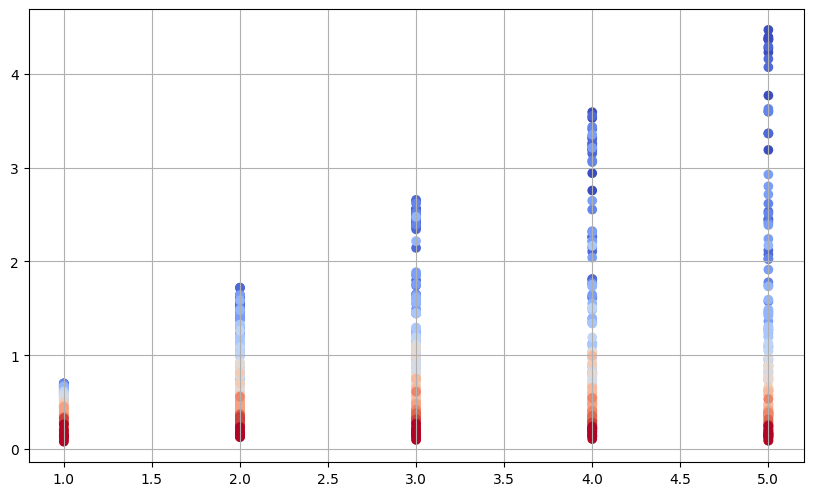

In [14]:
plt.scatter(df.generalmaxspeed, df.AverageSpeed, c=df.density, cmap=plt.cm.coolwarm)
plt.grid(True)

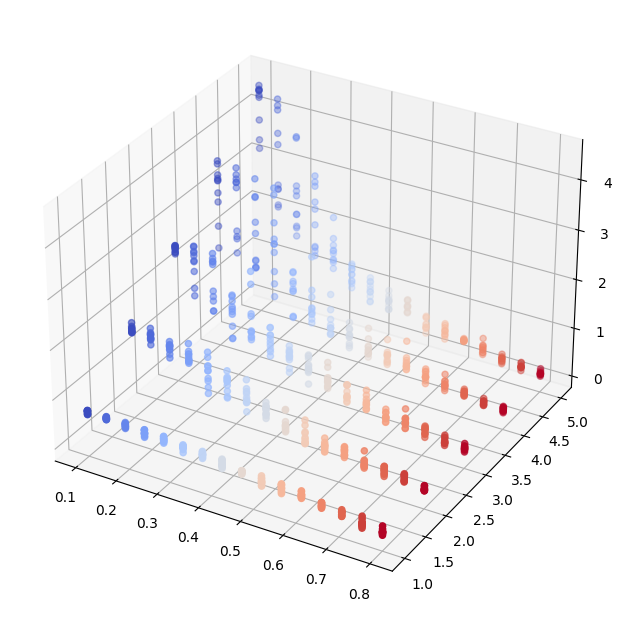

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
# fig.tight_layout(pad=4)
ax = Axes3D(fig)
ax.scatter(df.density, df.generalmaxspeed, df.AverageSpeed, c=df.density, cmap=plt.cm.coolwarm)
plt.show()